Set up logging

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
from unidecode import unidecode

In [5]:
import os
import json
import tempfile
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

Folder "c:\users\tomd\appdata\local\temp" will be used to save temporary dictionary and corpus.


Import gensim

In [6]:
from gensim import corpora, models, similarities

C:\Users\tomd\Anaconda2\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2017-07-12 11:02:25,887 : INFO : 'pattern' package not found; tag filters are not available for English


nltk libs for pre-processing

In [7]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.probability import FreqDist
from collections import defaultdict
from heapq import nlargest

get the single executive answers with 19 documents

In [8]:
path = 'C:\\Users\\tomd\\pda\\textout\\execEach\\'
fname = "Rob Sands_text_jun14_transcript_may31_seq_resulttranscripts_may29const_Q1_17.json"

json_data=open(path + fname ).read()

data = json.loads(json_data)


Load LM Uncertainty List of words

In [9]:
fh = open('C:\\Users\\tomd\\pda\\LM_Uncertainty.txt')


In [10]:
lmUcertWords = [x.strip().lower() for x in fh]

In [11]:
#lmUcertWords

Create the list of documents

In [12]:
docs = []

for entry in data['execResp']:
    #print entry
    docs.append(unidecode(entry))


In [13]:
#docs

In [14]:
len(docs)

19

In [36]:
docs[15]

"ACV growth has been and will continue to be a number one priority for the beer business and Modelo Especial in particular, when you say pick up, it's not like we wrapped at a particular point in time on distribution growth, it's what, that is what the sales organization basically is all about and does, okay. When companies like ourselves talk about execution or sales execution, they're talking about growing distribution first and foremost and then probably the number to think in sales organization execution is all about merchandising and add activity at retail. So that's what sales forces do. That's all they do, they run out and get distribution. They grow distribution and they work with the distributors and the retailers to maximize the merchandising opportunities."

set up stop words

In [16]:
customStopWords=set(stopwords.words('english')+list(punctuation))

In [17]:
#texts = [[word for word in document.lower().split() if word not in customStopWords]
#         for document in docs]

create list of tokens for each document 

In [18]:
texts = [[word for word in word_tokenize(document.lower())if word not in customStopWords]
         for document in docs]

and inspect number of tokens per documents

In [19]:
repLens = [len(text) for text in texts]
    

In [20]:
repLens

[70, 29, 91, 105, 74, 69, 73, 60, 40, 53, 3, 48, 57, 175, 113, 63, 72, 67, 8]

In [21]:
#sum(repLens)

In [22]:
#word_freq = FreqDist(texts[13])#texts[0]

In [48]:
#word_freq
texts[10]

["'s", 'totally', 'unpredictable']

For each documents check if the tokens are in the uncertainty list of words
If an uncertain word is found then sum the counts and calcualte a measure of 
uncertainty as a value between 0 and 1 and subtract this from 1. The higher the 
score the higher the uncertainty

In [24]:
#texts[0]
for i in range(len(repLens)):
    wrdCount = 0
    for token in texts[i]:
        #print token
        if token in lmUcertWords:
            wrdCount +=1
            print "Uncertain Word: ", token, " - doc id : ", i
    if wrdCount > 0:
        print "No. of Uncertain tokens found", wrdCount
        print "No. Tokens", repLens[i]
        umsr = 1 - float(repLens[i] - wrdCount)/ repLens[i]
        print "Uncertainty measure", umsr
        print "-----------------"
    


Uncertain Word:  probably  - doc id :  2
Uncertain Word:  maybe  - doc id :  2
No. of Uncertain tokens found 2
No. Tokens 91
Uncertainty measure 0.021978021978
-----------------
Uncertain Word:  sometimes  - doc id :  5
No. of Uncertain tokens found 1
No. Tokens 69
Uncertainty measure 0.0144927536232
-----------------
Uncertain Word:  somewhat  - doc id :  6
No. of Uncertain tokens found 1
No. Tokens 73
Uncertainty measure 0.013698630137
-----------------
Uncertain Word:  perhaps  - doc id :  9
Uncertain Word:  might  - doc id :  9
Uncertain Word:  might  - doc id :  9
No. of Uncertain tokens found 3
No. Tokens 53
Uncertainty measure 0.0566037735849
-----------------
Uncertain Word:  unpredictable  - doc id :  10
No. of Uncertain tokens found 1
No. Tokens 3
Uncertainty measure 0.333333333333
-----------------
Uncertain Word:  probably  - doc id :  12
Uncertain Word:  probably  - doc id :  12
No. of Uncertain tokens found 2
No. Tokens 57
Uncertainty measure 0.0350877192982
-------------

In [ ]:
Cohen Kappa

In [ ]:
from sklearn.metrics import cohen_kappa_score
>>> y_true = [2, 0, 2, 2, 0, 1]
>>> y_pred = [0, 0, 2, 2, 0, 2]
>>> cohen_kappa_score(y_true, y_pred)

Create Dictionary, BoW and tf-idf of Robs 19 Answers

In [25]:
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'RobExecUncertain.dict'))  # store the dictionary, for future reference
print(dictionary)

2017-07-12 11:03:48,585 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-07-12 11:03:48,589 : INFO : built Dictionary(552 unique tokens: [u'ale', u'focus', u'per', u'go', u'follow']...) from 19 documents (total 1270 corpus positions)
2017-07-12 11:03:48,591 : INFO : saving Dictionary object under c:\users\tomd\appdata\local\temp\RobExecUncertain.dict, separately None
2017-07-12 11:03:48,612 : INFO : saved c:\users\tomd\appdata\local\temp\RobExecUncertain.dict


Dictionary(552 unique tokens: [u'ale', u'focus', u'per', u'go', u'follow']...)


In [26]:
#for k, v in dictionary.token2id.iteritems():
#    print k, v

Create the BoW

In [27]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'RobExecUncertain.mm'), corpus)  # store to disk, for later use
#for c in corpus:
#    print(c)

2017-07-12 11:03:58,638 : INFO : storing corpus in Matrix Market format to c:\users\tomd\appdata\local\temp\RobExecUncertain.mm
2017-07-12 11:03:58,640 : INFO : saving sparse matrix to c:\users\tomd\appdata\local\temp\RobExecUncertain.mm
2017-07-12 11:03:58,641 : INFO : PROGRESS: saving document #0
2017-07-12 11:03:58,664 : INFO : saved 19x552 matrix, density=8.944% (938/10488)
2017-07-12 11:03:58,703 : INFO : saving MmCorpus index to c:\users\tomd\appdata\local\temp\RobExecUncertain.mm.index


Calculate the tfidf

In [28]:
tf_idf = models.TfidfModel(corpus)

2017-07-12 11:04:03,717 : INFO : collecting document frequencies
2017-07-12 11:04:03,717 : INFO : PROGRESS: processing document #0
2017-07-12 11:04:03,720 : INFO : calculating IDF weights for 19 documents and 551 features (938 matrix non-zeros)


Inspect 1 of the anwsers

In [30]:
#corpus_tf_idf = tf_idf[corpus]

corpus_tf_idf[10]
#for docu in corpus_tf_idf:
#     print(docu)

[(38, 0.026701303650248823),
 (341, 0.706854666951905),
 (342, 0.706854666951905)]

lookup the index value in the dictionay to find the token

In [50]:
dictionary.get(341)

u'unpredictable'

In [33]:
corpus_tf_idf[12]

[(28, 0.08351068543455017),
 (38, 0.005032178304584122),
 (58, 0.017169238361873885),
 (86, 0.14099018692171245),
 (88, 0.2710584719291071),
 (98, 0.14099018692171245),
 (111, 0.08351068543455017),
 (112, 0.20371026400539496),
 (116, 0.10185513200269748),
 (133, 0.039135054919014964),
 (176, 0.2114852803825687),
 (194, 0.13552923596455355),
 (215, 0.06039941599748701),
 (225, 0.30556539600809246),
 (237, 0.3340427417382007),
 (291, 0.10185513200269748),
 (321, 0.20371026400539496),
 (363, 0.13321517054453874),
 (364, 0.13321517054453874),
 (365, 0.13321517054453874),
 (366, 0.20371026400539496),
 (367, 0.13321517054453874),
 (368, 0.13321517054453874),
 (369, 0.13321517054453874),
 (370, 0.10185513200269748),
 (371, 0.13321517054453874),
 (372, 0.2664303410890775),
 (373, 0.13321517054453874),
 (374, 0.13321517054453874),
 (375, 0.13321517054453874),
 (376, 0.2664303410890775),
 (377, 0.13321517054453874),
 (378, 0.13321517054453874),
 (379, 0.2664303410890775),
 (380, 0.13321517054453

In [34]:
dictionary.get(98)

u'probably'

Explore word frequencies

In [35]:
corpus_tf_idf[15]

[(10, 0.09766581496994232),
 (38, 0.018848157193616044),
 (49, 0.07329069264322807),
 (58, 0.016076959318217465),
 (66, 0.036645346321614036),
 (75, 0.07819787133651193),
 (80, 0.06601031017315481),
 (81, 0.019467943633430403),
 (88, 0.04230236207156975),
 (98, 0.06601031017315481),
 (103, 0.027191939452451255),
 (133, 0.036645346321614036),
 (142, 0.036645346321614036),
 (152, 0.06601031017315481),
 (169, 0.06601031017315481),
 (175, 0.07819787133651193),
 (194, 0.04230236207156975),
 (197, 0.04883290748497116),
 (214, 0.06601031017315481),
 (243, 0.07819787133651193),
 (246, 0.19075054804939115),
 (281, 0.06601031017315481),
 (282, 0.07819787133651193),
 (421, 0.09537527402469557),
 (434, 0.3127914853460477),
 (448, 0.09537527402469557),
 (452, 0.09537527402469557),
 (461, 0.09537527402469557),
 (464, 0.12474023787623632),
 (465, 0.12474023787623632),
 (466, 0.12474023787623632),
 (467, 0.12474023787623632),
 (468, 0.12474023787623632),
 (469, 0.12474023787623632),
 (470, 0.124740237

In [59]:
dictionary.get(98)

u'probably'

In [27]:
import numpy as np

In [68]:
word_freq = FreqDist(texts[0])#texts[0]

In [87]:
print np.mean(repLens)
print np.std(repLens)
print max(repLens)
print min(repLens)

66.8421052632
37.2717801502
175
3


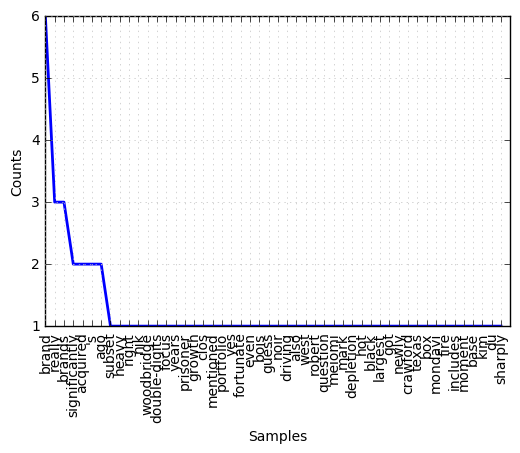

In [73]:
word_freq.plot(50, cumulative=False)

In [72]:
word_freq.most_common(50)

[('brand', 6),
 ('really', 3),
 ('brands', 3),
 ('significantly', 2),
 ('acquired', 2),
 ("'s", 2),
 ('ago', 2),
 ('subset', 1),
 ('heavy', 1),
 ('right', 1),
 ('nik', 1),
 ('woodbridge', 1),
 ('double-digits', 1),
 ('focus', 1),
 ('years', 1),
 ('prisoner', 1),
 ('growth', 1),
 ('clos', 1),
 ('mentioned', 1),
 ('portfolio', 1),
 ('yes', 1),
 ('fortunate', 1),
 ('even', 1),
 ('bois', 1),
 ('guess', 1),
 ('noir', 1),
 ('driving', 1),
 ('also', 1),
 ('west', 1),
 ('robert', 1),
 ('question', 1),
 ('meiomi', 1),
 ('mark', 1),
 ('depletion', 1),
 ('hot', 1),
 ('black', 1),
 ('largest', 1),
 ('got', 1),
 ('newly', 1),
 ('crawford', 1),
 ('texas', 1),
 ('box', 1),
 ('mondavi', 1),
 ('fire', 1),
 ('includes', 1),
 ('moment', 1),
 ('base', 1),
 ('kim', 1),
 ('du', 1),
 ('sharply', 1)]

In [74]:
dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'execsUnCertaintext.dict'))  # store the dictionary, for future reference
print(dictionary)

2017-06-14 22:20:01,309 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2017-06-14 22:20:01,313 : INFO : built Dictionary(552 unique tokens: [u'ale', u'focus', u'per', u'go', u'follow']...) from 19 documents (total 1270 corpus positions)
2017-06-14 22:20:01,315 : INFO : saving Dictionary object under c:\users\tomd\appdata\local\temp\execsEachtext.dict, separately None
2017-06-14 22:20:01,336 : INFO : saved c:\users\tomd\appdata\local\temp\execsEachtext.dict


Dictionary(552 unique tokens: [u'ale', u'focus', u'per', u'go', u'follow']...)


In [75]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'execsUnCertaintext.mm'), corpus)  # store to disk, for later use
#for c in corpus:
#    print(c)

2017-06-14 22:21:34,490 : INFO : storing corpus in Matrix Market format to c:\users\tomd\appdata\local\temp\execsEachtextLDA.mm
2017-06-14 22:21:34,492 : INFO : saving sparse matrix to c:\users\tomd\appdata\local\temp\execsEachtextLDA.mm
2017-06-14 22:21:34,493 : INFO : PROGRESS: saving document #0
2017-06-14 22:21:34,516 : INFO : saved 19x552 matrix, density=8.944% (938/10488)
2017-06-14 22:21:34,565 : INFO : saving MmCorpus index to c:\users\tomd\appdata\local\temp\execsEachtextLDA.mm.index


[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 6), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2)]
[(38, 1), (40, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 3), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 4), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2)]
[(2, 1), (8, 1), (9, 2), (12, 1), (13, 1), (16, 3), (17, 2), (26, 1), (29, 1), (38, 3), (45, 1), (49, 1), (52, 1), (56, 1), (58, 2), (66, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 3), (82, 2), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 4), (90, 1), (91, 3), (92, 1), (93, 1), (9

In [92]:
tf_idf = models.TfidfModel(corpus)

2017-06-16 11:54:11,280 : INFO : collecting document frequencies
2017-06-16 11:54:11,282 : INFO : PROGRESS: processing document #0
2017-06-16 11:54:11,283 : INFO : calculating IDF weights for 19 documents and 551 features (938 matrix non-zeros)


In [93]:
print(tf_idf)

TfidfModel(num_docs=19, num_nnz=938)


In [95]:
simer = similarities.Similarity(TEMP_FOLDER,tf_idf[corpus],
                                      num_features=len(dictionary))
print(simer)

2017-06-16 12:05:48,565 : INFO : starting similarity index under c:\users\tomd\appdata\local\temp


Similarity index with 19 documents in 0 shards (stored under c:\users\tomd\appdata\local\temp)


In [100]:
#sims = index[tf_idf[]]
#print(list(enumerate(sims)))

In [78]:
model = models.LdaModel(corpus, id2word=dictionary, num_topics=7, passes=100)

2017-06-14 22:23:42,561 : INFO : using symmetric alpha at 0.142857142857
2017-06-14 22:23:42,562 : INFO : using symmetric eta at 0.0018115942029
2017-06-14 22:23:42,563 : INFO : using serial LDA version on this node
2017-06-14 22:23:42,631 : INFO : running online LDA training, 7 topics, 100 passes over the supplied corpus of 19 documents, updating model once every 19 documents, evaluating perplexity every 19 documents, iterating 50x with a convergence threshold of 0.001000
2017-06-14 22:23:42,798 : INFO : -9.596 per-word bound, 774.0 perplexity estimate based on a held-out corpus of 19 documents with 1270 words
2017-06-14 22:23:42,799 : INFO : PROGRESS: pass 0, at document #19/19
2017-06-14 22:23:42,858 : INFO : topic #4 (0.143): 0.024*"business" + 0.017*"beer" + 0.017*"reflective" + 0.014*"'s" + 0.012*"would" + 0.012*"wine" + 0.011*"iri" + 0.011*"quarter" + 0.010*"probably" + 0.010*"think"
2017-06-14 22:23:42,859 : INFO : topic #0 (0.143): 0.019*"'s" + 0.019*"would" + 0.015*"really" +

In [79]:
# Prints the topics.
for top in model.print_topics():
  print top
print

2017-06-14 22:25:19,016 : INFO : topic #0 (0.143): 0.016*"'s" + 0.016*"quarter" + 0.016*"hot" + 0.016*"pinot" + 0.016*"noir" + 0.016*"would" + 0.012*"said" + 0.012*"first" + 0.012*"brand" + 0.012*"mean"
2017-06-14 22:25:19,017 : INFO : topic #1 (0.143): 0.038*"'s" + 0.027*"think" + 0.025*"like" + 0.016*"really" + 0.016*"say" + 0.016*"would" + 0.014*"sort" + 0.011*"new" + 0.011*"beer" + 0.011*"okay"
2017-06-14 22:25:19,019 : INFO : topic #2 (0.143): 0.038*"test" + 0.029*"well" + 0.020*"basically" + 0.020*"brand" + 0.020*"advertising" + 0.011*"back" + 0.011*"'re" + 0.011*"pretty" + 0.011*"extremely" + 0.011*"demonstrated"
2017-06-14 22:25:19,020 : INFO : topic #3 (0.143): 0.047*"'s" + 0.035*"growth" + 0.027*"distribution" + 0.016*"portfolio" + 0.016*"okay" + 0.016*"beer" + 0.016*"modelo" + 0.016*"especial" + 0.016*"brands" + 0.012*"point"
2017-06-14 22:25:19,022 : INFO : topic #4 (0.143): 0.045*"business" + 0.030*"reflective" + 0.023*"beer" + 0.023*"wine" + 0.023*"iri" + 0.016*"probably"

(0, u'0.016*"\'s" + 0.016*"quarter" + 0.016*"hot" + 0.016*"pinot" + 0.016*"noir" + 0.016*"would" + 0.012*"said" + 0.012*"first" + 0.012*"brand" + 0.012*"mean"')
(1, u'0.038*"\'s" + 0.027*"think" + 0.025*"like" + 0.016*"really" + 0.016*"say" + 0.016*"would" + 0.014*"sort" + 0.011*"new" + 0.011*"beer" + 0.011*"okay"')
(2, u'0.038*"test" + 0.029*"well" + 0.020*"basically" + 0.020*"brand" + 0.020*"advertising" + 0.011*"back" + 0.011*"\'re" + 0.011*"pretty" + 0.011*"extremely" + 0.011*"demonstrated"')
(3, u'0.047*"\'s" + 0.035*"growth" + 0.027*"distribution" + 0.016*"portfolio" + 0.016*"okay" + 0.016*"beer" + 0.016*"modelo" + 0.016*"especial" + 0.016*"brands" + 0.012*"point"')
(4, u'0.045*"business" + 0.030*"reflective" + 0.023*"beer" + 0.023*"wine" + 0.023*"iri" + 0.016*"probably" + 0.016*"market" + 0.016*"category" + 0.016*"spirits" + 0.016*"categories"')
(5, u'0.020*"would" + 0.017*"brand" + 0.014*"n\'t" + 0.014*"say" + 0.014*"really" + 0.014*"\'s" + 0.010*"yes" + 0.010*"lot" + 0.010*"ch

In [97]:
model.show_topics(1)
#model.get_topic_terms(0, topn=10)

[(2,
  u'0.038*"test" + 0.029*"well" + 0.020*"basically" + 0.020*"brand" + 0.020*"advertising" + 0.011*"back" + 0.011*"\'re" + 0.011*"pretty" + 0.011*"extremely" + 0.011*"demonstrated"')]